In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import re

import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import auth
from google.auth import default

from scipy.optimize import curve_fit




This notebook, **py-mcr_CurveFit**, is dedicated to calibrating the parameters of our theoretical model based on experimental data. The objective is to estimate strain-specific parameters, including growth rates ($\rho$) and antibiotic susceptibility coefficients ($\kappa$), using Monod growth curves and MIC data.

The outputs from this notebook provide the necessary parameter values for subsequent simulations of plasmid stability and bacterial population dynamics, which are explored in other parts of the study.


## Simple Bacterial Growth Model

We begin by fitting the Monod growth model to optical density (OD) measurements obtained from strains grown in isolation. The notebook employs non-linear least squares optimization to determine parameters such as the maximum growth rate and the specific affinity for resources. The Monod equation used is:

$$ g(R; \psi) = \rho \cdot \frac{R}{K_m + R} $$

where $g(R; \psi)$ represents the growth rate as a function of resource concentration ($R$) and strain-specific parameters ($\psi$).





In [2]:
def Monod(y, t, rho, muK):
    R, B = y
    this_K = 1.0
    m = muK * this_K
    dydt = [-m * R / (this_K + R) * B, rho * m * R / (this_K + R) * B]
    return dydt

def simulate_model(rho, muK, y0, t):
    solution = odeint(Monod, y0, t, args=(rho, muK))
    R, B = solution.T
    return t, B

## Curve Fitting

Next, we fit dose-response curves and use the L-BFGS-B algorithm to estimate the antibiotic susceptibility coefficients ($\kappa$), ensuring these values remain within biologically realistic bounds.

In [3]:

def model_fit( t, rho, muK, strain):

    initial_R = 1.0  # Assume some initial resource concentration
    initial_B = data[strain + ' MeanOD'].iloc[0]  # Use the first measurement as initial bacterial density
    y0 = [initial_R, initial_B]
    _, B = simulate_model(rho, muK, y0, t)
    return B

def print_fit_results(popt, pcov):
    # Parameters are rho and muK
    rho, muK = popt
    print(f"Optimized Parameters:")
    print(f"rho (resource conversion rate): {rho:.4e}")  # Exponential notation for readability
    print(f"muK (mu/K parameter): {muK:.4e}")

    # Print the covariance matrix
    #print("\nCovariance Matrix of the Parameters:")
    #print(pcov)

    # Optionally, you could also print the standard deviations of the parameters
    # which are the square roots of the diagonal elements of the covariance matrix
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of the parameters
    print(f"Std of rho: {perr[0]:.4e}")
    print(f"Std of muK: {perr[1]:.4e}")

def CFUs(ODs):
    b1 = 1002614811.71
    b2 = 12526559.79
    return b1 * ODs + b2

In [4]:
def plot_od_sim(df, strain, popt):
    """
    Plot the optical density data with error bars and overlay the model predictions.

    Parameters:
    - df: DataFrame containing the data.
    - strain: The strain name to use for labeling the data.
    - popt: Tuple of fitted parameters (rho, muK).
    """
    # Extract experimental data
    time = df['Time (h)']

    mean_od = df[strain + ' MeanOD']
    std_od = df[strain + ' StdOD']


    # Calculate the standard error of the mean (SEM)
    sample_size = 3  # Adjust this if you have a different number of replicates
    sem = std_od / np.sqrt(sample_size)

    # Simulate the model with the optimized parameters
    initial_conditions = [1.0, mean_od.iloc[0]]  # Assuming some initial resource and the initial OD from your data
    simulated_t, simulated_B = simulate_model(*popt, initial_conditions, time.values)

    # Create the plot
    plt.figure(figsize=(6, 4))
    # Plot experimental data
    plt.errorbar(time, mean_od, yerr=sem, fmt='.-',color='grey', ecolor='grey', capsize=2, label=f'{strain}')

    # Plot model predictions
    plt.plot(simulated_t, simulated_B, label='Model fit', linestyle='-', marker='', color='k', lw=3)

    plt.xlabel('Time (hours)')
    plt.ylabel('Density (cells/ml)')
    plt.title(f' {strain}')
    plt.legend()
    plt.grid(False)  # Optionally turn off the grid
    plt.show()


In [5]:
def export_monod_parameters(sheet_url, tab_name, strain, rho, muK):
    # Authenticate and create the client
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Open the worksheet by URL
    sh = gc.open_by_url(sheet_url)

    # Check if worksheet exists, if not create it and set headers
    try:
        worksheet = sh.worksheet(tab_name)
    except gspread.WorksheetNotFound:
        worksheet = sh.add_worksheet(title=tab_name, rows="100", cols="20")
        headers = ['name', 'color', 'specie', 'strain', 'type', 'PCN', 'MIC', 'conj_rate', 'VKm', 'rho', 'seg_rate', 'kappa', 'beta', 'chi','colistin']
        worksheet.append_row(headers)  # Append the headers once when creating the worksheet

    # Check if the strain name contains '_Colistin' and remove it
    contains_colistin = '_Colistin' in strain
    modified_strain = strain.replace('_Colistin', '')

    # Determine the type based on the content within parentheses in the modified strain name
    type_match = re.search(r'\(([^)]+)\)', modified_strain)
    if type_match:
        type_strain = type_match.group(1)
    else:
        type_strain = 'WT'

    # Clean the strain name by removing any parenthetical content
    clean_strain = re.sub(r'\(.*\)', '', modified_strain).strip()

    # Determine the color based on the strain prefix
    strain_to_color = {'J53': '#FF0000', 'WJ1': '#00FF00', 'E30': '#0000FF'}  # Example color mapping
    color = next((strain_to_color[key] for key in strain_to_color if clean_strain.startswith(key)), '')

    # Prepare data with defaults and specific values
    data_values = {
        **default_parameters,
        'name': clean_strain,
        'color': color,
        'specie': '',
        'strain': clean_strain,
        'type': type_strain,
        'VKm': f"{muK:.4e}",
        'rho': f"{rho:.4e}",
        'colistin': contains_colistin
    }

    # Prepare the data to be appended using the header order
    headers = worksheet.row_values(1)  # Assuming the first row contains headers
    data = [data_values.get(header, '') for header in headers]

    # Append the data to the worksheet
    worksheet.append_row(data)

    print("Monod parameters exported successfully")

## Load experimental data

In [6]:
default_parameters = {
    'color': '#000000',
    'specie': 'X',
    'PCN': 2,
    'MIC': 0.5,
    'conj_rate': 1e-3,
    'seg_rate': 0.002,
    'kappa': 1.00E-04,
    'beta':0.5,
    'chi':1
}
strain_to_color = {
    'J53': '#FF0000',  # Red
    'WJ1': '#00FF00',  # Green
    'E30': '#0000FF'   # Blue
}

In [7]:
def load_data(sheet_url, tab_name, strain):
    # Authenticate and create the client
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Open the worksheet by URL and get the specific tab by name
    sh = gc.open_by_url(sheet_url)
    worksheet = sh.worksheet(tab_name)  # Ensure tab name is correct

    # Get all the data from the sheet
    data = worksheet.get_all_values()

    # Convert to DataFrame
    headers = data[0]  # Assumes the first row is headers
    df = pd.DataFrame(data[1:], columns=headers)

    # Convert the first column to numeric for time, if it's the time column
    if 'Time (h)' in df.columns:
        df['Time (h)'] = pd.to_numeric(df['Time (h)'], errors='coerce')

    # Filter columns by exact strain name match and convert them to numeric
    strain_columns = [col for col in df.columns if col.strip() == strain]
    print("Matching Columns:", strain_columns)  # Debug: Show matching columns

    if not strain_columns:
        print(f"No columns found for strain {strain}.")
        return None

    # Handle each column by its position to ensure uniqueness
    for i, col in enumerate(df.columns):
        if col.strip() == strain:
            df.iloc[:, i] = pd.to_numeric(df.iloc[:, i], errors='coerce')

    # If there are multiple columns for the strain, calculate their mean and std
    if len(strain_columns) > 1:
        df_mean = df[strain_columns].mean(axis=1)
        df_std = df[strain_columns].std(axis=1)
    else:
        df_mean = df[strain_columns[0]]  # Only one column data directly used as mean
        df_std = pd.Series([0] * len(df), index=df.index)  # Std is zero since there's no variation

    result = pd.DataFrame({
        'Time (h)': df['Time (h)'],
        strain + ' MeanOD': CFUs(df_mean),
        strain + ' StdOD': CFUs(df_std)
    })

    return result




** Strain: E30
Matching Columns: ['E30', 'E30', 'E30']
Optimized Parameters:
rho (resource conversion rate): 8.2055e+08
muK (mu/K parameter): 1.2526e-09
Std of rho: 5.4735e+06
Std of muK: 3.1923e-11


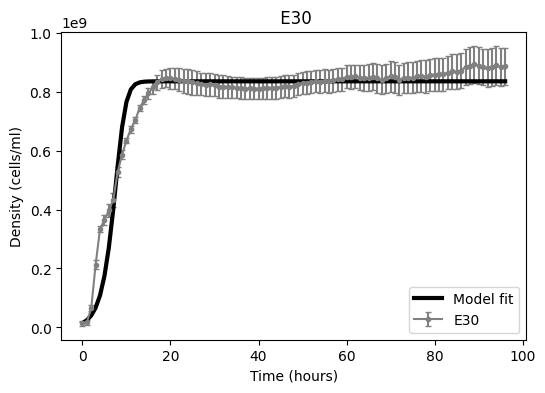

Monod parameters exported successfully


** Strain: E30_Colistin
Matching Columns: ['E30_Colistin', 'E30_Colistin', 'E30_Colistin']
Optimized Parameters:
rho (resource conversion rate): 5.7953e+08
muK (mu/K parameter): 2.1366e-09
Std of rho: 6.5172e+06
Std of muK: 1.0537e-10


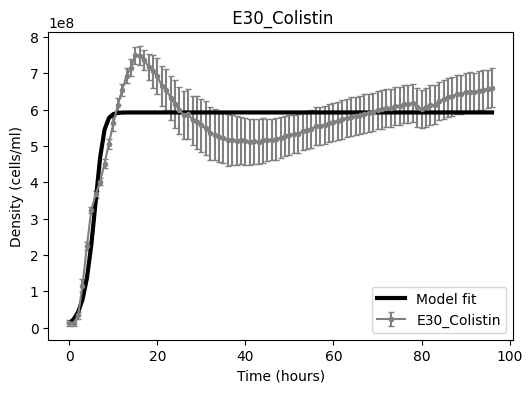

Monod parameters exported successfully


** Strain: WJ1_Colistin
Matching Columns: ['WJ1_Colistin', 'WJ1_Colistin', 'WJ1_Colistin']
Optimized Parameters:
rho (resource conversion rate): 1.0450e+09
muK (mu/K parameter): 1.2946e-09
Std of rho: 5.8992e+06
Std of muK: 3.0337e-11


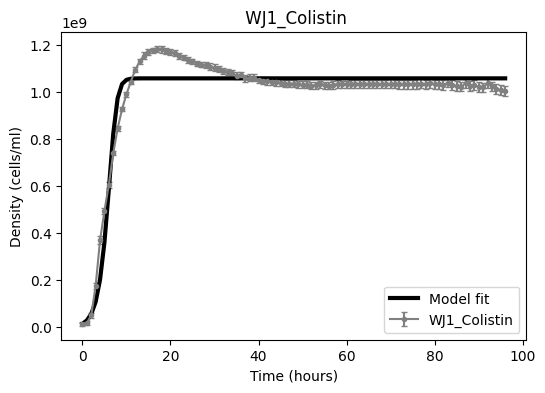

Monod parameters exported successfully


** Strain: J53(pWJ1)_Colistin
Matching Columns: ['J53(pWJ1)_Colistin', 'J53(pWJ1)_Colistin', 'J53(pWJ1)_Colistin']
Optimized Parameters:
rho (resource conversion rate): 1.0998e+09
muK (mu/K parameter): 8.7362e-10
Std of rho: 5.5199e+06
Std of muK: 1.4745e-11


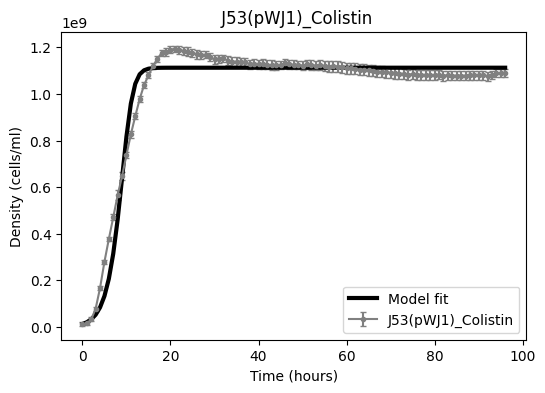

Monod parameters exported successfully


** Strain: J53(pWJ1)
Matching Columns: ['J53(pWJ1)', 'J53(pWJ1)', 'J53(pWJ1)']
Optimized Parameters:
rho (resource conversion rate): 1.1522e+09
muK (mu/K parameter): 8.2242e-10
Std of rho: 6.1510e+06
Std of muK: 1.5026e-11


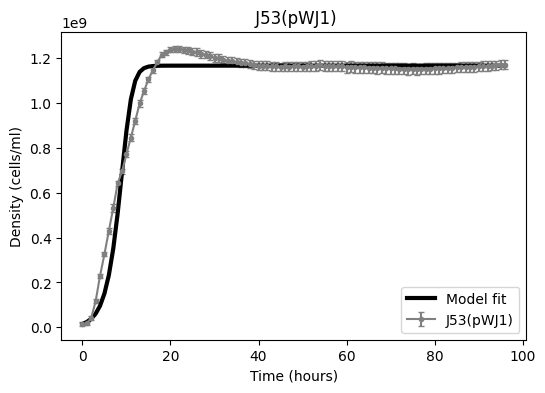

Monod parameters exported successfully


** Strain: J53
Matching Columns: ['J53', 'J53', 'J53']
Optimized Parameters:
rho (resource conversion rate): 1.3002e+09
muK (mu/K parameter): 1.0058e-09
Std of rho: 7.2828e+06
Std of muK: 2.1271e-11


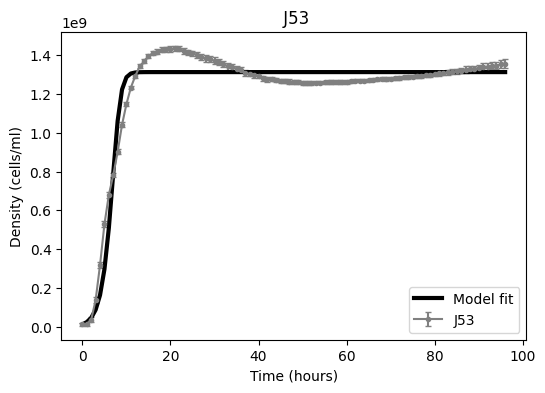

Monod parameters exported successfully


** Strain: J53(pE30)_Colistin
Matching Columns: ['J53(pE30)_Colistin', 'J53(pE30)_Colistin', 'J53(pE30)_Colistin']
Optimized Parameters:
rho (resource conversion rate): 1.1014e+09
muK (mu/K parameter): 8.6154e-10
Std of rho: 4.9939e+06
Std of muK: 1.3217e-11


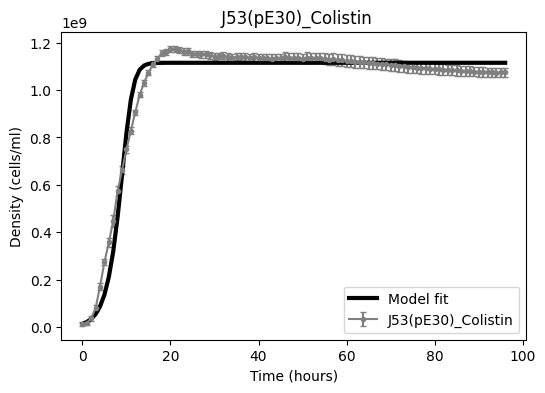

Monod parameters exported successfully


** Strain: Jing9
Matching Columns: ['Jing9']
Optimized Parameters:
rho (resource conversion rate): 1.2873e+09
muK (mu/K parameter): 2.4078e-10
Std of rho: 1.9683e+07
Std of muK: 1.1151e-11


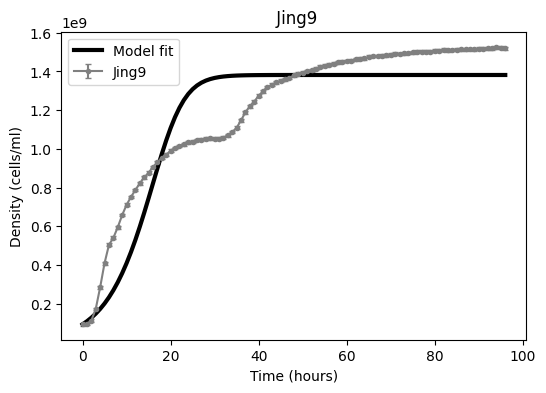

Monod parameters exported successfully


** Strain: WJ1
Matching Columns: ['WJ1', 'WJ1', 'WJ1']
Optimized Parameters:
rho (resource conversion rate): 1.1139e+09
muK (mu/K parameter): 1.0429e-09
Std of rho: 4.8744e+06
Std of muK: 1.9527e-11


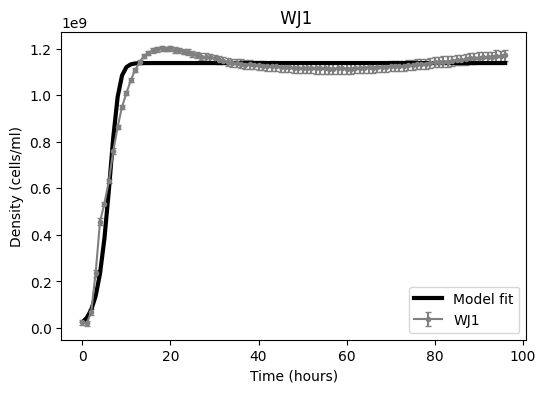

Monod parameters exported successfully


** Strain: J53(pE30)
Matching Columns: ['J53(pE30)', 'J53(pE30)', 'J53(pE30)']
Optimized Parameters:
rho (resource conversion rate): 1.1053e+09
muK (mu/K parameter): 8.7129e-10
Std of rho: 5.0967e+06
Std of muK: 1.3705e-11


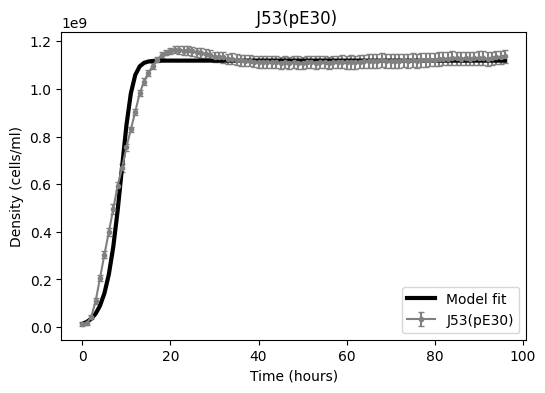

Monod parameters exported successfully


In [8]:

# Example usage
sheet_url = 'https://docs.google.com/spreadsheets/d/1nAyi0XfzWstjuXvePPPcXTNLWUyeztl7TNH2b4CKrbw'
strains={'E30','WJ1','J53(pE30)','J53(pWJ1)','J53','E30_Colistin','WJ1_Colistin','J53(pE30)_Colistin','J53(pWJ1)_Colistin', 'Jing9'} #,,'J53_Colistin'

for strain in strains:
  print("\n\n** Strain: %s"%strain)
  tab_name_data='OD'
  data = load_data(sheet_url, tab_name_data, strain)
  if data is not None:

    time = data['Time (h)'].values
    mean_od = data[strain + ' MeanOD'].values

    popt, pcov = curve_fit(lambda t, rho, muK: model_fit(t, rho, muK, strain), time, mean_od, p0=[1e9, 1e-11])


    rho, muK = popt
    print_fit_results(popt, pcov)


    plot_od_sim(data, strain, popt)

    tab_name_parameters = 'Monod_parameters'
    export_monod_parameters(sheet_url, tab_name_parameters, strain, rho, muK)

In [9]:
def get_strain_parameters(sheet_url, tab_name, strain, type_strain, colistin):
    # Authenticate and create the client for Google Sheets access
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Open the worksheet by URL and get the specific tab by name
    sh = gc.open_by_url(sheet_url)
    worksheet = sh.worksheet(tab_name)  # Ensure tab name is correct

    # Get all the data from the sheet and convert to DataFrame
    data = worksheet.get_all_values()
    headers = data[0]  # Assumes the first row is headers
    df = pd.DataFrame(data[1:], columns=headers)

    # Convert the 'colistin' column to a boolean (assuming it's stored as text "TRUE" or "FALSE")
    df['colistin'] = df['colistin'].str.upper() == 'TRUE'

    # Filter rows based on the 'name', 'type', and matching 'colistin' status
    strain_data = df[(df['name'] == strain) & (df['type'] == type_strain) & (df['colistin'] == colistin)]

    # Display the result
    if not strain_data.empty:
        print(f"Parameters for strain '{strain}' of type '{type_strain}', with Colistin={colistin}:")
    else:
        print(f"No data found for strain '{strain}' of type '{type_strain}', with Colistin={colistin}.")

    return strain_data


# Example usage
tab_name = 'Monod_parameters'
strain = 'J53'
type_strain = 'pWJ1'
colistin = False

get_strain_parameters(sheet_url, tab_name, strain, type_strain, colistin)


Parameters for strain 'J53' of type 'pWJ1', with Colistin=False:


,name,color,specie,strain,type,PCN,MIC,conj_rate,VKm,rho,seg_rate,kappa,colistin,description
3,J53,#FF0000,,J53_PWJ1,pWJ1,2,8192,0.001,8.2242e-10,1.1522e+09,0.002,1.00E-04,False,
27,J53,#FF0000,,J53,pWJ1,2,0.5,0.001,8.2242e-10,1.1522e+09,0.002,0.0001,False,
36,J53,#FF0000,,J53,pWJ1,2,0.5,0.001,8.2242e-10,1.1522e+09,0.002,0.0001,False,
45,J53,#FF0000,,J53,pWJ1,2,0.5,0.001,8.2242e-10,1.1522e+09,0.002,0.0001,False,
57,J53,#FF0000,,J53,pWJ1,2,0.5,0.001,8.2242e-10,1.1522e+09,0.002,0.0001,False,
65,J53,#FF0000,,J53,pWJ1,2,0.5,0.001,8.2242e-10,1.1522e+09,0.002,0.0001,False,
